# An introductional notebook to HEP analysis in C++

<p>In this notebook you can find an easy set of commands that show some basic computing techniques commonly used in High Energy Physics (HEP) analyzes.</p>

<p>It also shows how to create an histogram, fill it and draw it. Moreover it is an introduction to [ROOT](https://root.cern.ch/) too. The final output is a plot with the number of leptons.</p>

Based on ATLAS opendata notebooks (http://opendata.atlas.cern/release/2020/documentation/notebooks/intro.html)


The library used is [ROOT](https://root.cern.ch/), a scientific data analysis software framework that provides a large set of functionalities needed to deal with big data processing, statistical analysis, visualisation and storage.

<p>At first we have to include several helpers that will support our analysis:</p>

In [1]:
#include <iostream>
#include <string>
#include <stdio.h>

Next we have to open the data that we want to analyze. As described above the data is stored in a _*.root_ file. This is a root file containing tracks and calorimeter clusters

In [2]:
TFile *file = TFile::Open("Data_8TeV.root"); 

The next step is to define a tree named _tree_ to get the data out of the _*.root_ file. The tree in this root file is called "mini". We will then print the contents of the tree to find the names of the variables. 

In [3]:
TTree *tree = (TTree*) file->Get("mini");
tree->Print()

******************************************************************************
*Tree    :mini      : 4-vectors + variables required for scaling factors     *
*Entries : 14945674 : Total =      3737586466 bytes  File  Size = 1366006484 *
*        :          : Tree compression factor =   2.74                       *
******************************************************************************
*Br    0 :runNumber : runNumber/I                                            *
*Entries : 14945674 : Total  Size=   59789737 bytes  File Size  =     297928 *
*Baskets :       70 : Basket Size=    1224192 bytes  Compression= 200.68     *
*............................................................................*
*Br    1 :eventNumber : eventNumber/I                                        *
*Entries : 14945674 : Total  Size=   59789885 bytes  File Size  =   44412272 *
*Baskets :       70 : Basket Size=    1224192 bytes  Compression=   1.35     *
*...................................................

Activate variables 

In [4]:

Bool_t e_trig;
Bool_t mu_trig;
Bool_t good_vtx;
UInt_t lep_n;
UInt_t jet_n;
Float_t MET;
Float_t MET_phi;
Float_t mcw;

Float_t lep_pt[10];  
Float_t lep_eta[10];  
Float_t lep_phi[10];  
Float_t lep_E[10];  
Int_t lep_type[10];  
Float_t lep_ptcone30[10];
Float_t lep_etcone20[10];

Float_t jet_pt[10];  
Float_t jet_eta[10];  
Float_t jet_jvf[10];  
Float_t jet_mv1[10];  


tree->SetBranchAddress("mcWeight", &mcw);
tree->SetBranchAddress("trigE", &e_trig);
tree->SetBranchAddress("trigM", &mu_trig);
tree->SetBranchAddress("hasGoodVertex", &good_vtx);
tree->SetBranchAddress("lep_n", &lep_n);
tree->SetBranchAddress("jet_n", &jet_n);
tree->SetBranchAddress("met_et", &MET);
tree->SetBranchAddress("met_phi", &MET_phi);

tree->SetBranchAddress("lep_pt", &lep_pt);
tree->SetBranchAddress("lep_eta", &lep_eta);
tree->SetBranchAddress("lep_phi", &lep_phi);
tree->SetBranchAddress("lep_E", &lep_E);
tree->SetBranchAddress("lep_type", &lep_type);
tree->SetBranchAddress("lep_ptcone30", &lep_ptcone30);
tree->SetBranchAddress("lep_etcone20", &lep_etcone20);

tree->SetBranchAddress("jet_pt", &jet_pt);
tree->SetBranchAddress("jet_eta", &jet_eta);
tree->SetBranchAddress("jet_jvf", &jet_jvf);
tree->SetBranchAddress("jet_MV1", &jet_mv1);

In [5]:
TCanvas *canvas0 = new TCanvas("Canvas0","0",800,600);

Create histograms: Leading jet pT and all jets pT 

In [6]:
TH1F *cutflow = new TH1F("Cutflow","Cutflow; Cut; Events",20,0,10);

TH1F *hist_lep_pt = new TH1F("lep pT","Leptons pT; pT(GeV); Events",100,0,200);
TH1F *hist_lep_eta = new TH1F("lep eta","Leptons eta; eta; Events",20,-5,5);
TH1F *hist_track_isol = new TH1F("track Isol","Track Isolation; pTcone/pT; Events",20,-0.1,0.5);
TH1F *hist_cal_isol = new TH1F("cal Isol","Calorimeter Isolation; pTcone/pT; Events",20,-0.1,0.5);


TH1F *hist_njets = new TH1F("n-jets","Number of jets; Jet multiplicity; Events",10,0,10);
TH1F *hist_jet_pt = new TH1F("jet pT","Jets pT; pT(GeV); Events",100,0,200);
TH1F *hist_jet_eta = new TH1F("jet eta","Jets eta; eta; Events",20,-5,5);
TH1F *hist_jet_jvf = new TH1F("jet JVF","Jets JVF; JVF; Events",20,-1,1);
TH1F *hist_jet_mv1 = new TH1F("jet MV1","Jets MV1; mv1; Events",20,0,1);
TH1F *hist_nbjets = new TH1F("n-bjets","Number of b jets; b Jet multiplicity; Events",10,0,10);

TH1F *hist_MET = new TH1F("Missing ET", "MET; Et, Events", 100, 0, 200);
TH1F *hist_MWT = new TH1F("W Mass", "MWT; Et, Events", 100, 0, 200);

Loop and fill histograms

In [7]:
int nentries, nbytes, i;
nentries = (Int_t)tree->GetEntries();

int cut1 = 0;
int cut2 = 0;
int cut3 = 0;
int cut4 = 0;
int cut5 = 0;
int cut6 = 0;
int cut7 = 0;
int cut8 = 0;


for (i = 0; i < nentries; i++)
{
    nbytes = tree->GetEntry(i);   

    //First cut: Good vertex
    if(!good_vtx) continue;
    cut1++;
    cutflow->Fill(1);

    //Second cut: Trigger
    if(!e_trig && !mu_trig) continue;
    cut2++;
    cutflow->Fill(2);
       
    // Preselection of good leptons                                                                                
    int n_mu=0;
    int n_el=0;
    int n_lep=0;

    
    //Loop over leptons
    for(unsigned int i=0; i<lep_n; i++){
        if( lep_pt[i] < 25000.) continue; 
        if( lep_ptcone30[i]/lep_pt[i] > 0.15 ) continue; 
        if( lep_etcone20[i]/lep_pt[i] > 0.15 ) continue;  
        if( lep_type [i]==13 && TMath::Abs(lep_eta[i]) < 2.5 ){
            n_mu++;}
        if( lep_type [i]==11 && TMath::Abs(lep_eta[i]) < 2.47 && (TMath::Abs(lep_eta[i]) < 1.37 || TMath::Abs(lep_eta[i]) > 1.52  ) ){
            n_el++;}
        
        //Add electrons and extract the index for the good lepton
        
        n_lep++;
        }
   
    //Select events with only 1 good lepton and fill the cutflow histogram 
    //Third cut (one good lepton):
    if(n_lep!=1) continue;
    cutflow->Fill(3); 
    cut3++;

  
    int n_jets=0;
    int n_bjets=0;
    
    //Number of jets distribution
    hist_njets->Fill(jet_n);
    
    //Fourth cut: At least 4 jets
    if(jet_n<4) continue; 
    cutflow->Fill(4); 
    cut4++;

    for(unsigned int j=0; j<jet_n; j++){
        // Apply jet cuts to find the good jets
        if(jet_pt[j] < 25000.) continue;
        if(jet_eta[j] > 2.5) continue; //Eta cut
        if(jet_pt[j] < 50000 && jet_eta[j] < 2.4 && TMath::Abs(jet_jvf[j]) <0.5 ) continue;  // JVF cleaning 
            n_jets++;
        if(jet_mv1[j] < 0.7892) continue;
            n_bjets++  ;  // cut on 0.7892 MV1 and count the number of b-jets
    }
    

  
    //Fifth cut: At least 4 good jets
    if(n_jets<4) continue; 
    cutflow->Fill(5); 
    cut5++;
   
    //Sixth cut: at least one b-jet
    if(n_bjets <2) continue;
    cutflow->Fill(6); 
    cut6++;
 
    //Seventh cut: MET > 30 GeV
    if(MET<30000) continue;
    cutflow->Fill(7); 
    cut7++;
  
    // TLorentzVector definitions                                                               
    TLorentzVector Lepton  = TLorentzVector();
    TLorentzVector  MeT  = TLorentzVector();
    
    
    //To complete: Lorentz vectors for the lepton and MET. Use SetPtEtaPhiE().
    
    Lepton.SetPtEtaPhiE(lep_pt[0],lep_eta[0],lep_phi[0],lep_E[0]);
    MeT.SetPtEtaPhiE(MET,0,MET_phi,MET);
    

    
    //Calculation of the mTW using TLorentz vectors             
   float mTW = sqrt(2*Lepton.Pt()*MeT.Et()*(1-cos(Lepton.DeltaPhi(MeT))));

    //Eight cut: mTW > 30 GeV
    if(mTW < 30000.) continue;
    cutflow->Fill(8); 
    cut8++;
    
}



    
std::cout << "Done!" << std::endl;
std::cout << "All events:" << nentries << std::endl;
std::cout << "Cut1:" << cut1 << std::endl;
std::cout << "Cut2:" << cut2 << std::endl;
std::cout << "Cut3:" << cut3 << std::endl;
std::cout << "Cut4:" << cut4 << std::endl;
std::cout << "Cut5:" << cut5 << std::endl;
std::cout << "Cut6:" << cut6 << std::endl;
std::cout << "Cut7:" << cut7 << std::endl;
std::cout << "Cut8:" << cut8 << std::endl;

Done!
All events:14945674
Cut1:14656440
Cut2:14656440
Cut3:11561801
Cut4:61995
Cut5:61791
Cut6:10827
Cut7:8577
Cut8:7199


<p>Draw</p>

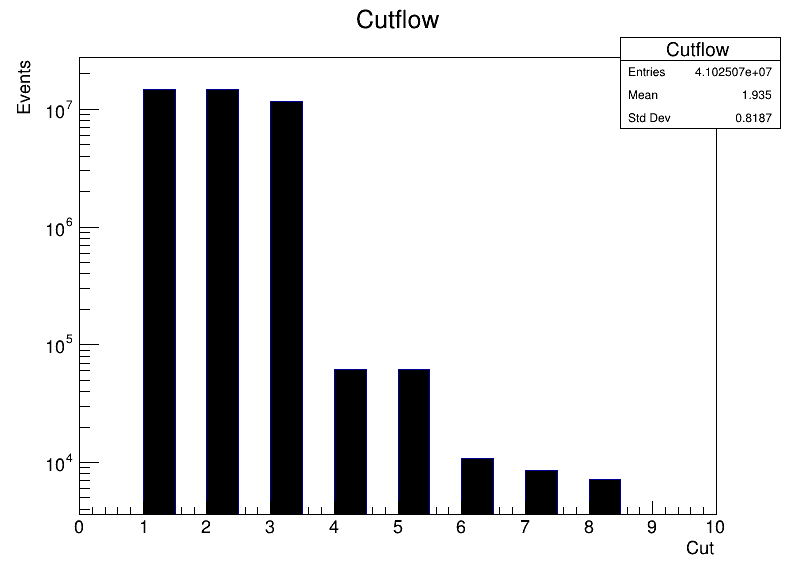

In [8]:
TCanvas *canvas1 = new TCanvas("Canvas","",800,600);
cutflow->SetFillColor(01);
cutflow->Draw("");
canvas1->SetLogy();
canvas1->Draw();

In [9]:
int nentries, nbytes, i;
nentries = (Int_t)tree->GetEntries();

for (i = 0; i < nentries; i++)
{
    nbytes = tree->GetEntry(i); 
    
    for(unsigned int j = 0 ; j < lep_n ; j++)
    {   
    hist_lep_pt->Fill(lep_pt[j]/1000);
    }   
}

std::cout << "Done!" << std::endl;

Done!


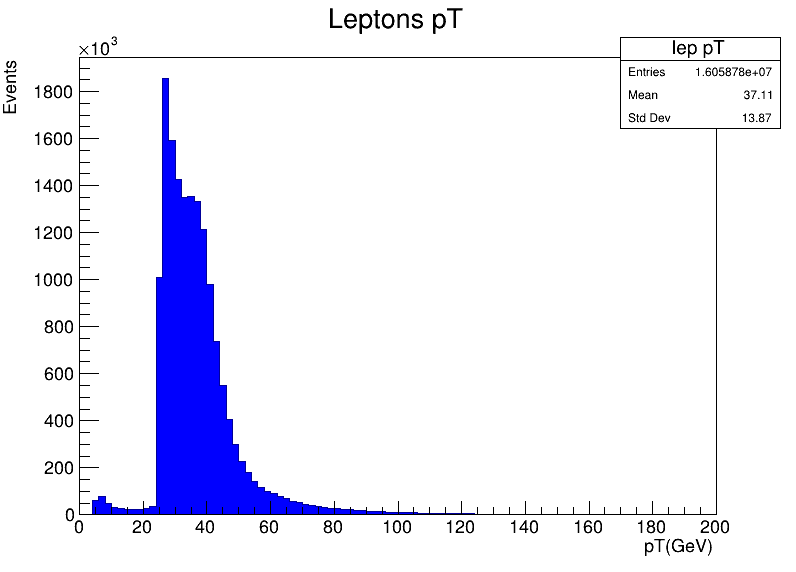

In [10]:
TCanvas *canvas2 = new TCanvas("Canvas2","2",800,600);
hist_lep_pt->SetFillColor(04);
hist_lep_pt->Draw();
canvas2->Draw();

In [11]:
int nentries, nbytes, i;
nentries = (Int_t)tree->GetEntries();

for (i = 0; i < nentries; i++)
{
    nbytes = tree->GetEntry(i); 
    
    for(int j = 0; j < lep_n; j++)
    {
    hist_lep_eta->Fill(lep_eta[j]);       
    }
}

std::cout << "Done!" << std::endl;

Done!


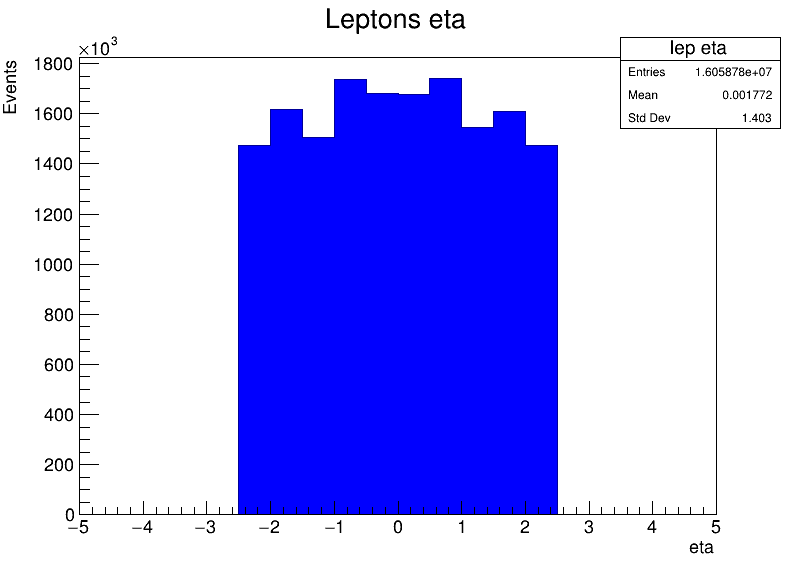

In [12]:
TCanvas *canvas3 = new TCanvas("Canvas3","3",800,600);
hist_lep_eta->SetFillColor(04);
hist_lep_eta->Draw();
canvas3->Draw();

In [13]:
int nentries, nbytes, i;
nentries = (Int_t)tree->GetEntries();

for (i = 0; i < nentries; i++)
{
    nbytes = tree->GetEntry(i); 
    
    for(unsigned int j= 0 ; j < lep_n ; j++)
    {
    hist_track_isol->Fill(lep_ptcone30[j]/lep_pt[j]);
    }    
}

std::cout << "Done!" << std::endl;

Done!


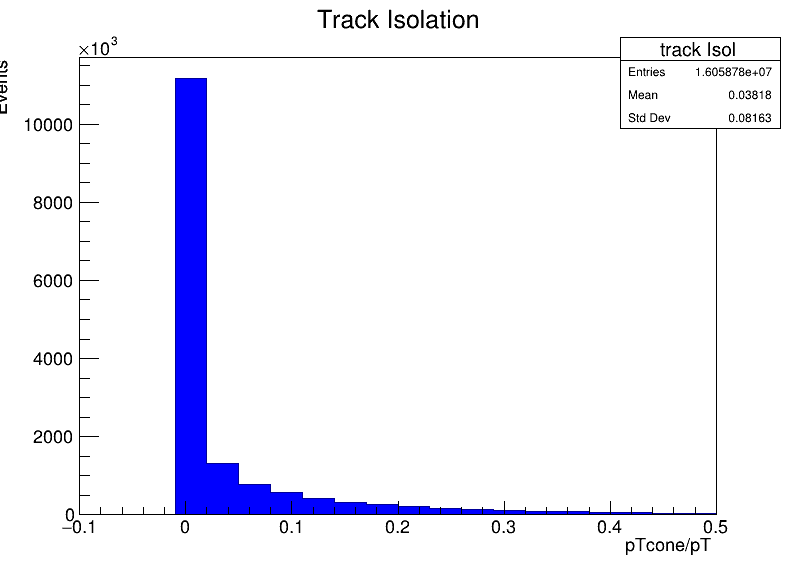

In [14]:
TCanvas *canvas4 = new TCanvas("Canvas4","4",800,600);
hist_track_isol->SetFillColor(04);
hist_track_isol->Draw();
canvas4->Draw();

In [15]:
int nentries, nbytes, i;
nentries = (Int_t)tree->GetEntries();

for (i = 0; i < nentries; i++)
{
    nbytes = tree->GetEntry(i); 
    
    for(unsigned int j= 0 ; j < lep_n ; j++)
    {
    hist_cal_isol->Fill(lep_etcone20[j]/lep_pt[j]);
    }    
}

std::cout << "Done!" << std::endl;

Done!


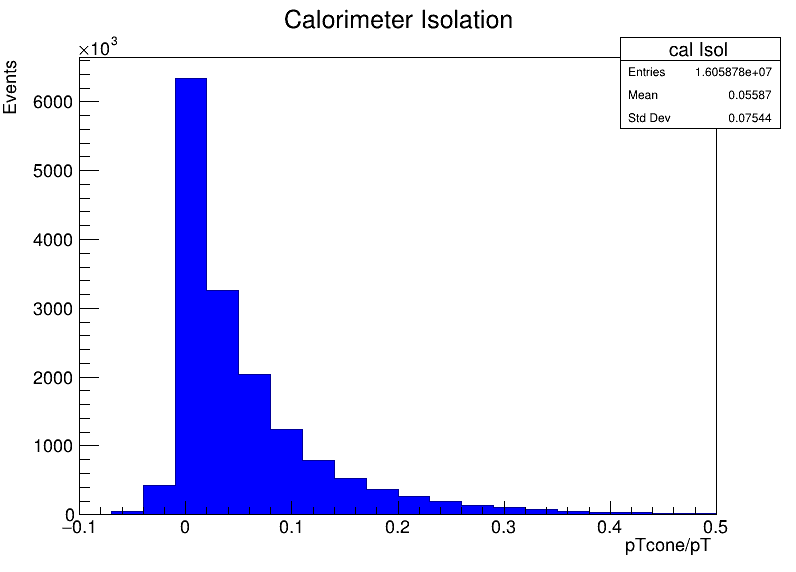

In [16]:
TCanvas *canvas5 = new TCanvas("Canvas5","5",800,600);
hist_cal_isol->SetFillColor(04);
hist_cal_isol->Draw();
canvas5->Draw();

In [17]:
int nentries, nbytes, i;
nentries = (Int_t)tree->GetEntries();

for (i = 0; i < nentries; i++)
{
    nbytes = tree->GetEntry(i); 
    
    int n_jets = 0;
    for(int j=0 ; j < jet_n ; j++)
    {
    hist_njets->Fill(n_jets);
    }
    
}

std::cout << "Done!" << std::endl;

Done!


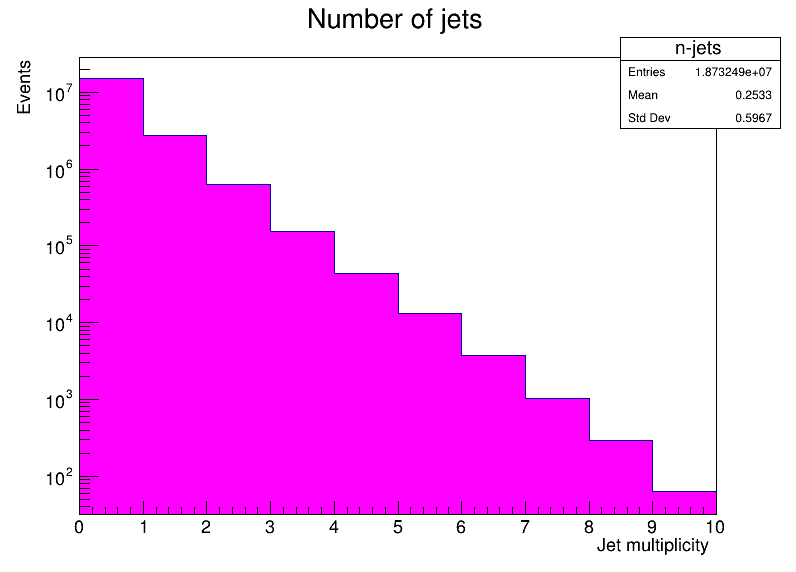

In [18]:
TCanvas *canvas6 = new TCanvas("Canvas6","6",800,600);
hist_njets->SetFillColor(06);
hist_njets->Draw();
canvas6->SetLogy();
canvas6->Draw();

In [19]:
int nentries, nbytes, i;
nentries = (Int_t)tree->GetEntries();

for (i = 0; i < nentries; i++)
{
    nbytes = tree->GetEntry(i); 
    
    for(int j = 0 ; j < jet_n ; j++)
    {   
    hist_jet_pt->Fill(jet_pt[j]/1000);
    }   
}

std::cout << "Done!" << std::endl;

Done!


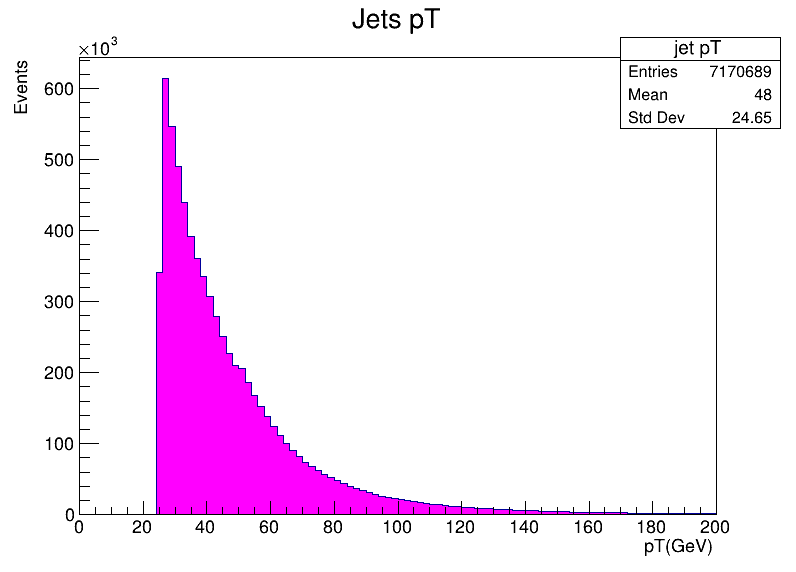

In [20]:
TCanvas *canvas7 = new TCanvas("Canvas7","7",800,600);
hist_jet_pt->SetFillColor(06);
hist_jet_pt->Draw();
canvas7->Draw();

In [21]:
int nentries, nbytes, i;
nentries = (Int_t)tree->GetEntries();

for (i = 0; i < nentries; i++)
{
    nbytes = tree->GetEntry(i); 
    
    for(int j=0 ; j < jet_n ; j++ )
    {
        hist_jet_eta->Fill(jet_eta[j]);       
    }  
}

std::cout << "Done!" << std::endl;

Done!


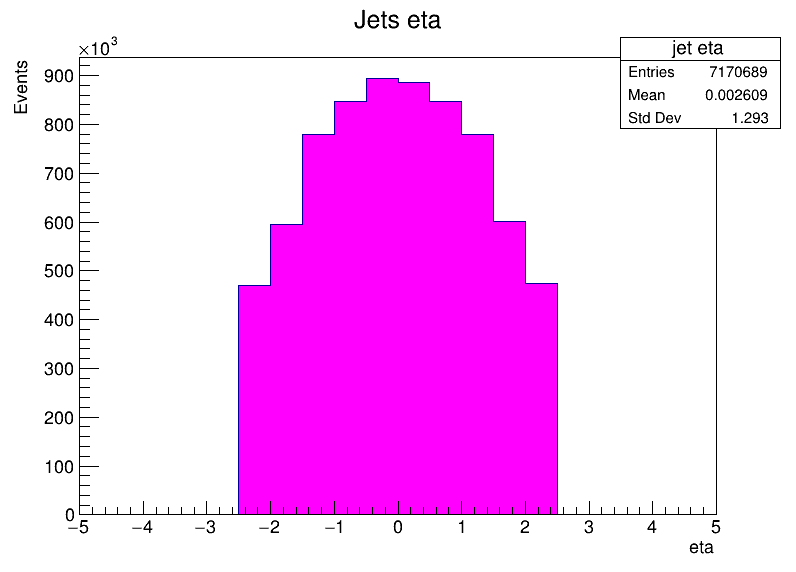

In [22]:
TCanvas *canvas8 = new TCanvas("Canvas8","8",800,600);
hist_jet_eta->SetFillColor(06);
hist_jet_eta->Draw();
canvas8->Draw();

In [23]:
int nentries, nbytes, i;
nentries = (Int_t)tree->GetEntries();

for (i = 0; i < nentries; i++)
{
    nbytes = tree->GetEntry(i); 
    
    for(int j = 0 ; j < jet_n ; j++)
    {   
    hist_jet_jvf->Fill(jet_jvf[j]);
    }   
}

std::cout << "Done!" << std::endl;

Done!


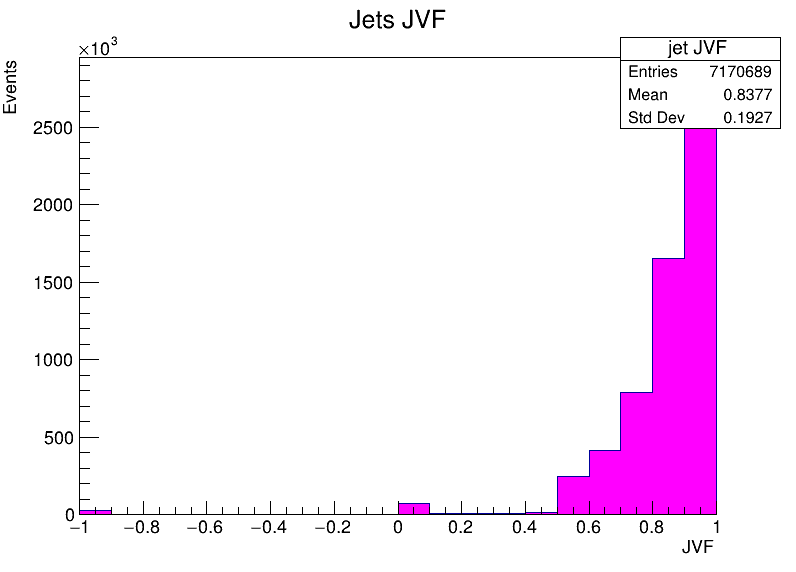

In [24]:
TCanvas *canvas9 = new TCanvas("Canvas9","9",800,600);
hist_jet_jvf->SetFillColor(06);
hist_jet_jvf->Draw();
canvas9->Draw();

In [25]:
int nentries, nbytes, i;
nentries = (Int_t)tree->GetEntries();

for (i = 0; i < nentries; i++)
{
    nbytes = tree->GetEntry(i); 
    
    for(int j = 0 ; j < jet_n ; j++)
    {    
    hist_jet_mv1->Fill(jet_mv1[j]);       
    }
}

std::cout << "Done!" << std::endl;

Done!


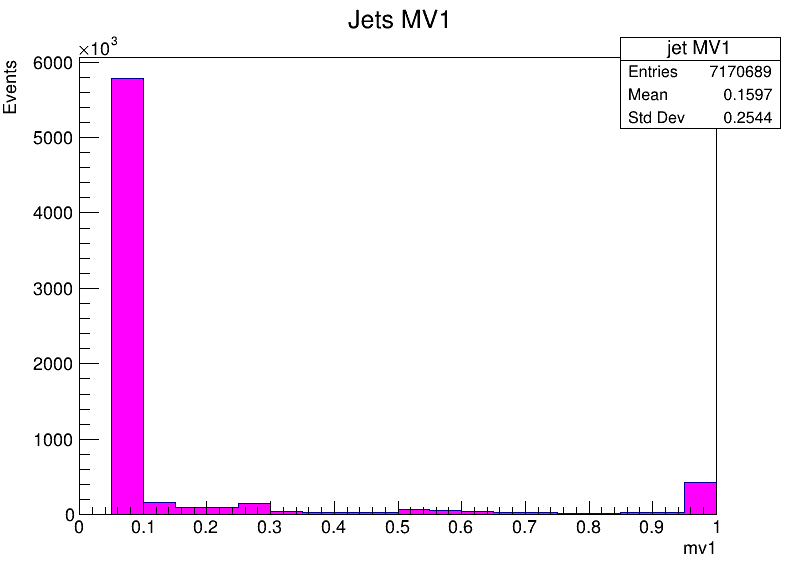

In [26]:
TCanvas *canvas10 = new TCanvas("Canvas10","10",800,600);
hist_jet_mv1->SetFillColor(06);
hist_jet_mv1->Draw();
canvas10->Draw();

In [27]:
int nentries, nbytes, i;
nentries = (Int_t)tree->GetEntries();

for (i = 0; i < nentries; i++)
{
    nbytes = tree->GetEntry(i); 
    int n_bjets = 0;

    for(unsigned int j=0; j<jet_n; j++)
    {
        if(jet_mv1[j] > 0.7892){
            n_bjets++  ;}        
    }   
    hist_nbjets->Fill(n_bjets);    
}

std::cout << "Done!" << std::endl;

Done!


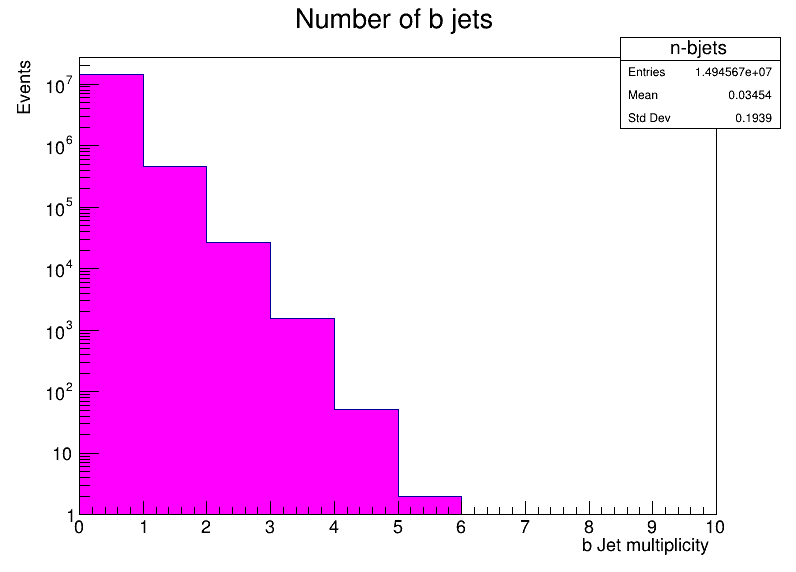

In [28]:
TCanvas *canvas11 = new TCanvas("Canvas11","11",800,600);
hist_nbjets->SetFillColor(06);
hist_nbjets->Draw();
canvas11->SetLogy();
canvas11->Draw();

In [7]:
int nentries, nbytes, i;
nentries = (Int_t)tree->GetEntries();

for (i = 0; i < nentries; i++)
{
   nbytes = tree->GetEntry(i); 
   hist_MET->Fill(MET/1000);       
    
}

std::cout << "Done!" << std::endl;

Done!


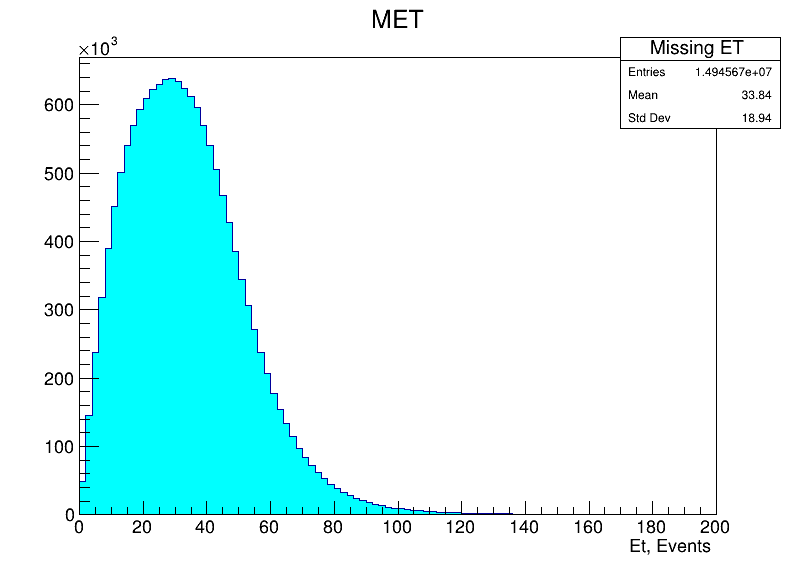

In [8]:
TCanvas *canvas12 = new TCanvas("Canvas12","12",800,600);
hist_MET->SetFillColor(07);
hist_MET->Draw();
canvas12->Draw();

In [9]:
int nentries, nbytes, i;
nentries = (Int_t)tree->GetEntries();

for (i = 0; i < nentries; i++)
{
    nbytes = tree->GetEntry(i); 
    
    TLorentzVector Lepton  = TLorentzVector();
    TLorentzVector  MeT  = TLorentzVector();
    
    Lepton.SetPtEtaPhiE(lep_pt[0],lep_eta[0],lep_phi[0],lep_E[0]);
    MeT.SetPtEtaPhiE(MET,0,MET_phi,MET);
    

    //Calculation of the mTW using TLorentz vectors             
    float mTW = sqrt(2*Lepton.Pt()*MeT.Et()*(1-cos(Lepton.DeltaPhi(MeT))));
    hist_MWT->Fill(mTW/1000);       
    
}

std::cout << "Done!" << std::endl;

Done!


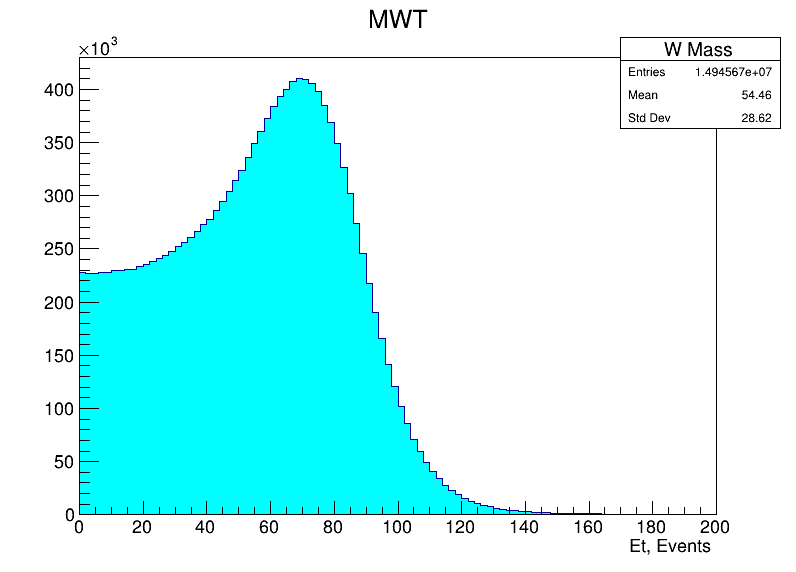

In [10]:
TCanvas *canvas13 = new TCanvas("Canvas13","13",800,600);
hist_MWT->SetFillColor(07);
hist_MWT->Draw();
canvas13->Draw();